# <center> BCG 2 LDA - Labeling </center>

LDA Trial Notes: 
1. 直接使用已拆分的短句+cn_stopwords，问题：短句太短，stopwords不够多，话题分类不够明确，肉眼可见许多话题内的费词(topic 40, words50)
2. 直接使用原始的长文本+合并的hit_words_v1，问题：keywords在不同topics下的重复次数多 (topic 40, words100)
3. 使用原始长文本中自带的标签拆分，问题：(topic 40, words100)

In [45]:
import re
import numpy as np
import pandas as pd
import jieba
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

In [65]:
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

## Preparation

In [46]:
# data = pd.read_excel("NEV_Car_Data.xlsx", sheet_name = '2021年所有口碑')
# data = pd.read_excel("NEV_Car_Data.xlsx", sheet_name = 'trial')
data = pd.read_excel("trial.xlsx", sheet_name = 'Sheet1')

In [ ]:
data.head()

In [48]:
data.shape

(1135, 61)

## Preprocessing

In [55]:
# 直接使用短句
# speech_list = list(data["短句"]) 

# 直接使用不切分的内容
# speech_list = list(data["内容"])

# 使用原标签自带的内容
# data.fillna("",inplace=True)
all_reviews = data.iloc[:,-13:] # choose all the review topics columns
speech_list = all_reviews.values.tolist() # convert df into a list
speech_list = list(itertools.chain(*speech_list)) # flatten the list
speech_list = list(filter(''.strip, speech_list)) # dropna

In [56]:
speech_list

['最满意】',
 '最满意】1.内饰，新的设计师水平不错，摆脱了之前比亚迪平庸的内饰设计。多色可调氛围灯，停车有呼吸效果。门板，中控台的翻毛皮很有档次感，整车内饰较为高档。2.操控不错，方向没有虚位，车很整很跟手，刹车距离短，悬架调教适中，操控没问题。 3.配置一直是比亚迪的特色，同价位配置要好出很多，这个顶配唐，很多东西都有配，车道保持，并线辅助，交通标志识别，后车厢感应，自带行车记录仪。 基本算是常规高配车子的大部分有了，为什么是大部分？个人感觉有几个简单的配置，比亚迪应该给顶配车型加的。后面谈。',
 '最不满意】为什么是意料之上，确实期待之下呢？以前买过一台比亚迪S6。 1.5T顶配的那个。 才十多万，家人开着去过新疆，西藏，四川，河北，陕西，还有其他好多地方。 配置高，到现在所有功能都正常，没有坏掉一个非损耗件。马上就8年了。在这8年中，中国车企取得了巨大的进步。因此对新款比亚迪的当家头牌顶配，充满了更多的期待。 这个也几乎是2021上半年时，比亚迪里，价格最高端的其中的一款家用轿车了。下面是我用车后一些失望之处吧。1。前雷达是干嘛用的？ 旧款S6的前雷达都可以识别前方障碍物。而2021款唐，启动直接挂D挡后，前雷达不工作。除非先倒挡，然后在D挡，前雷达才激活工作。且只有当障碍物近30厘米左右才会报警。如果那个预碰撞报警是以这个前雷达为感应器的话，那这个预碰撞的功能几乎等于没用。2。个人觉得可以加一个抬头显。毕竟是比亚迪最贵一款家用轿车了。又以配置为王出身的比亚迪，这个实用配置应该加。3. 车机系统很落后，新势力造车那几家，车机比手机还灵敏，前后排不同座位的语音可以分区判断，但是我的唐却连APP打开都要等半天。这个体验感太差了。这是10年以前的电子产品体验感。语音识别，报一个歌名十几遍也识别不正确。这不应该是我们当下新能源车的水平呀。4. 交流充电桩太难找了。现在很多都是直流快充，出去充电太闹心。应该官方出一个转换头，可以插直流快充桩。这样就好多了。5. 后备箱一脚踢感应难操作，50%成功率，双手抱一堆东西，傻傻的一直踢感应而不开，太尴尬了，尤其是不得不放下东西，用手打开后备箱的时候，自己都觉得尴尬。6.长途高速不友好，跑长途亏电后，油耗偏高。总续航里程不理想。 从上海浦东机场到嘉兴市来回3个多小时的高速。 出发时满油满电，往返回来，电早已经到底了，油箱

In [57]:
#stop words dictionary loading
#jieba.load_userdict(userdict)
with open('hit_stopwords_v2.txt') as f:
    stop_words = f.readlines()
    
#delete the space in stop words
stop_words = [w.replace('\n', '') for w in stop_words]  #s.replace(old, new[, max])
stop_words = [w.replace(' ', '') for w in stop_words]

In [58]:
rule = re.compile(r"[^\u4e00-\u9fa5]") # 匹配中文字符的正则表达式
#只需要中文pattern = '[\u4e00-\u9fa5]+'
# https://blog.csdn.net/qq_42374697/article/details/111386047
speech_list = [list(jieba.cut(rule.sub('', speech))) for speech in speech_list]
for idx, speech in enumerate(speech_list):
    speech_list[idx] = ' '.join([word for word in speech if word.strip() not in stop_words])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2y/cc3k_r1n5hn5lldc6dr9r4y40000gn/T/jieba.cache
Loading model cost 0.848 seconds.
Prefix dict has been built successfully.


In [59]:
speech_list[:3]

['满意',
 '满意 内饰 新 设计师 水平 不错 摆脱 比亚迪 平庸 内饰 设计 多色 可调 氛围 灯 停车 呼吸 效果 门板 中控台 翻 毛皮 档次 感 整车 内饰 高档 操控 不错 方向 虚位 车 很整 手 刹车 距离 短 悬架 调教 适中 操控 配置 比亚迪 特色 同价位 配置 顶配 唐 东西 有配 车道 并线 辅助 交通标志 识别 车厢 感应 自带 行车 记录仪 算是 常规 高配 车子 大部分 大部分 个人感觉 几个 简单 配置 比亚迪 顶配 车型 加 谈',
 '满意 意料 之上 确实 期待 之下 买过 一台 比亚迪 顶配 十多万 家人 开着 去过 新疆 西藏 四川 河北 陕西 好多 地方 配置 高到 功能 坏掉 非 损耗 件 年 年 中 中国 车企 新款 比亚迪 当家 头牌 顶配 充满 期待 上半年 时 比亚迪 里 价格 端的 一款 家用轿车 用车 失望 之处 前 雷达 干嘛 旧款 前 雷达 识别 前方 障碍物 而款 唐 启动 挂挡 后前 雷达 工作 先倒 挡 挡 前 雷达 激活 工作 障碍物 厘米 报警 预 碰撞 报警 前 雷达 感应器 预 碰撞 功能 等于 没用 加 抬头 显 比亚迪 贵 一款 家用轿车 配置 王 出身 比亚迪 实用 配置 加车 机系统 落后 新 势力 造车 几家 车机 手机 灵敏 前后排 座位 语音 分区 判断 唐 打开 半天 体验 感太差 年 电子产品 体验 感 语音 识别 报 歌名 十几遍 识别 正确 新能源 车 水平 交流 充电 桩 太难 找 直流 快充 充电 太 闹心 官方 转换头 插 直流 充桩 好多 后备箱 一脚 踢 感应 难 操作 成功率 双手 抱 一堆 东西 傻傻的 踢 感应 不开 太 尴尬 放下 东西 用手 打开 后备箱 尴尬 长途 高速 友好 跑 长途 亏电后 油耗 偏高 总 续航 里程 理想 上海浦东 机场 嘉兴市 来回 小时 高速 出发 时满油 满电 往返 回来 电早 油箱 燃油 车 高速 一半 油量 交流 充电 桩 难 找 情况 工况 亏电 跑 算算 费用 锐界 省 不到 是因为 充电 桩 商用 一度 电 原因 差点 忘记 槽 点 轮毂 轮胎 配 轮毂 扁平 轮胎 不合理 四驱 雪地 爬坡 模式 扁 轮胎 适合 车 备胎 轮胎 选择 爆胎 扁平 比小 厚胎 车主 自行 升级 缺气 保用 轮胎 这车重 防

## Topics Division on all comments

In [61]:
# 目前二级标签33个
n_topics = 40   # topic数量
n_top_words = 80   # 话题内的关键词数量

tf_vectorizer = CountVectorizer(token_pattern='[\u4e00-\u9fff]{2,6}',max_features=500)
tf = tf_vectorizer.fit_transform(speech_list)
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

feature_names = tf_vectorizer.get_feature_names()
compoments = lda.components_

/Users/judyyzhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [73]:
lda

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=40, random_state=0)

In [62]:
#convert the topics into a dataframe
topic_dic = {}
for no in range(n_topics):
    topic = ([feature_names[i] for i in compoments[no].argsort()[:-n_top_words - 1:-1]])
    topic_dic["topic"+str(no+1)] = topic

topic_df = pd.DataFrame(topic_dic)

In [63]:
topic_df

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,topic40
0,真的,感受,内饰,这车,日常,外观,入手,确实,满意,汽车,...,感觉,不错,喜欢,车子,底盘,功能,操控,油耗,完美,性价比
1,表现,品牌,设计,车灯,出行,设计,反正,蔚来,地方,每次,...,动力,整体,包括,这辆,行驶,智能,方向盘,能耗,一辆车,价格
2,这方面,国产车,做工,实在,挺不错,颜值,一辆,服务,接受,希望,...,特别,感觉,只能,这台,习惯,语音,感觉,混动,满意,价位
3,特别,媳妇,感觉,解决,压力,造型,选择,小鹏,特别,家里,...,强劲,比较满意,东西,家里人,过程,科技,转向,省油,算是,配置
4,发现,享受,颜色,传统,没什么,好看,适合,免费,电池,老婆,...,燃油,提升,车辆,质感,感觉,手机,驾驶,能力,特别,保养
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,大气,选择,导航,启动,帅气,轮胎,新能源,显得,导航,舒适性,...,算是,行驶,音响,操控性,空气,焦虑,行车,大部分,老婆,当初
76,媳妇,音乐,氛围,车机,买车,很强,实惠,样子,优势,行驶,...,选择,一段时间,网上,力度,减震,提升,路段,原因,材质,确实
77,实用性,模式,语音,提车,简单,优秀,一段时间,数据,舒适,车里,...,原因,新车,行车,油耗,前后排,续航,表现,网上,公里,出色
78,语音,平常,贯穿,免费,比亚迪,很大,感受,生活,很大,轮胎,...,导航,乘坐,特斯拉,合适,空间设计,车里,优秀,平常,安静,整车


In [64]:
topic_df.to_excel("lda_topics.xlsx",encoding='utf8',index=False)

## WordCloud For later use

In [66]:
speech = ' '.join(speech_list)

In [67]:
speech[:10]

'满意 满意 内饰 新'

In [68]:
l = speech.split(' ')
l[:10]

['满意', '满意', '内饰', '新', '设计师', '水平', '不错', '摆脱', '比亚迪', '平庸']

In [69]:
newtxt = ''.join(l)
newtxt[:10]

'满意满意内饰新设计师'

In [70]:
counts = Counter(l)

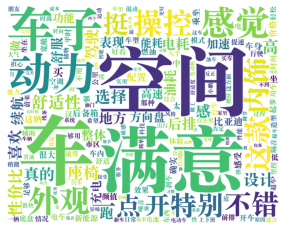

In [72]:
# img = Image.open("mask_pic.png") 
# img = Image.new(mode="RGB", size=(1000, 1000))
# mask = np.array(img)
font = '/Library/Fonts/Songti.ttc'
wc = WordCloud(font_path = font,
#                mask=mask,
               width = 1500,
               height = 1200,
               background_color='white',
               max_words=200,
               stopwords=stop_words).fit_words(counts).to_file('中文词云图.jpg')

# word cloud display
plt.imshow(wc)
plt.axis("off")  
plt.show()

## Find the best topic number for LDA

In [ ]:
def Lda_Model():
    # 载入情感分析后的数据
    posdata = pd.read_excel("./tmp/posdata_shouji.xlsx")
    negdata = pd.read_excel("./tmp/negdata_shouji.xlsx")

    from gensim import corpora, models
    # 建立词典
    pos_dict = corpora.Dictionary([[i] for i in posdata['word']])  # 正面
    neg_dict = corpora.Dictionary([[i] for i in negdata['word']])  # 负面

    # 建立语料库
    pos_corpus = [pos_dict.doc2bow(j) for j in [[i] for i in posdata['word']]]  # 正面
    neg_corpus = [neg_dict.doc2bow(j) for j in [[i] for i in negdata['word']]]  # 负面

    # 主题数寻优

    # 构造主题数寻优函数
    def cos(vector1, vector2):  # 余弦相似度函数
        dot_product = 0.0
        normA = 0.0
        normB = 0.0
        for a, b in zip(vector1, vector2):
            dot_product += a * b
            normA += a ** 2
            normB += b ** 2
        if normA == 0.0 or normB == 0.0:
            return (None)
        else:
            return (dot_product / ((normA * normB) ** 0.5))

            # 主题数寻优

    def lda_k(x_corpus, x_dict):

        # 初始化平均余弦相似度
        mean_similarity = []
        mean_similarity.append(1)

        # 循环生成主题并计算主题间相似度
        for i in np.arange(2, 11):
            lda = models.LdaModel(x_corpus, num_topics=i, id2word=x_dict)  # LDA模型训练
            for j in np.arange(i):
                term = lda.show_topics(num_words=50)

            # 提取各主题词
            top_word = []
            for k in np.arange(i):
                top_word.append([''.join(re.findall('"(.*)"', i)) \
                                 for i in term[k][1].split('+')])  # 列出所有词

            # 构造词频向量
            word = sum(top_word, [])  # 列出所有的词
            unique_word = set(word)  # 去除重复的词

            # 构造主题词列表，行表示主题号，列表示各主题词
            mat = []
            for j in np.arange(i):
                top_w = top_word[j]
                mat.append(tuple([top_w.count(k) for k in unique_word]))

            p = list(itertools.permutations(list(np.arange(i)), 2))
            l = len(p)
            top_similarity = [0]
            for w in np.arange(l):
                vector1 = mat[p[w][0]]
                vector2 = mat[p[w][1]]
                top_similarity.append(cos(vector1, vector2))

            # 计算平均余弦相似度
            mean_similarity.append(sum(top_similarity) / l)
        return (mean_similarity)

    # 计算主题平均余弦相似度
    pos_k = lda_k(pos_corpus, pos_dict)
    neg_k = lda_k(neg_corpus, neg_dict)

    # 绘制主题平均余弦相似度图形
    from matplotlib.font_manager import FontProperties
    font = FontProperties(size=14)
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(211)
    ax1.plot(pos_k)
    ax1.set_xlabel('正面评论LDA主题数寻优', fontproperties=font)

    ax2 = fig.add_subplot(212)
    ax2.plot(neg_k)
    ax2.set_xlabel('负面评论LDA主题数寻优', fontproperties=font)
    plt.show()

    # LDA主题分析
    pos_lda = models.LdaModel(pos_corpus, num_topics=3, id2word=pos_dict)
    neg_lda = models.LdaModel(neg_corpus, num_topics=3, id2word=neg_dict)
    print(pos_lda.print_topics(num_words=10))

    print(neg_lda.print_topics(num_words=10))

In [105]:
def Lda_Model():
    # 载入情感分析后的数据
    data = pd.read_excel("trial.xlsx", sheet_name = 'Sheet1')
    
    all_reviews = data.iloc[:,-13:] # choose all the review topics columns
    
    speech_list = all_reviews.values.tolist() # convert df into a list
    speech_list = list(itertools.chain(*speech_list)) # flatten the list
    #speech_list = list(filter(str.strip, speech_list)) # dropna
    
    with open('hit_stopwords_v2.txt') as f:
        stop_words = f.readlines()
    
    #delete the space in stop words
    stop_words = [w.replace('\n', '') for w in stop_words]  #s.replace(old, new[, max])
    stop_words = [w.replace(' ', '') for w in stop_words]
    rule = re.compile(r"[^\u4e00-\u9fa5]") # 匹配中文字符的正则表达式

    speech_list = [list(jieba.cut(rule.sub(' ', speech))) for speech in speech_list]
    # 建立词典
    df_dict = corpora.Dictionary([[i] for i in speech_list])
    # 建立语料库
    corpus = [df_dict.doc2bow(j) for j in [[i] for i in speech_list]]
    
    # combine keywords from one segment of review
    for idx, speech in enumerate(speech_list):
        speech_list[idx] = ' '.join([word for word in speech if word.strip() not in stop_words])

    from gensim import corpora, models

    # 主题数寻优

    # 构造主题数寻优函数
    def cos(vector1, vector2):  # 余弦相似度函数
        dot_product = 0.0
        normA = 0.0
        normB = 0.0
        for a, b in zip(vector1, vector2):
            dot_product += a * b
            normA += a ** 2
            normB += b ** 2
        if normA == 0.0 or normB == 0.0:
            return (None)
        else:
            return (dot_product / ((normA * normB) ** 0.5))

            # 主题数寻优

    def lda_k(x_corpus, x_dict):

        # 初始化平均余弦相似度
        mean_similarity = []
        mean_similarity.append(1)

        # 循环生成主题并计算主题间相似度
        for i in np.arange(2, 11):
            lda = models.LdaModel(x_corpus, num_topics=i, id2word=x_dict)  # LDA模型训练
            for j in np.arange(i):
                term = lda.show_topics(num_words=50)

            # 提取各主题词
            top_word = []
            for k in np.arange(i):
                top_word.append([''.join(re.findall('"(.*)"', i)) \
                                 for i in term[k][1].split('+')])  # 列出所有词

            # 构造词频向量
            word = sum(top_word, [])  # 列出所有的词
            unique_word = set(word)  # 去除重复的词

            # 构造主题词列表，行表示主题号，列表示各主题词
            mat = []
            for j in np.arange(i):
                top_w = top_word[j]
                mat.append(tuple([top_w.count(k) for k in unique_word]))

            p = list(itertools.permutations(list(np.arange(i)), 2))
            l = len(p)
            top_similarity = [0]
            for w in np.arange(l):
                vector1 = mat[p[w][0]]
                vector2 = mat[p[w][1]]
                top_similarity.append(cos(vector1, vector2))

            # 计算平均余弦相似度
            mean_similarity.append(sum(top_similarity) / l)
        return (mean_similarity)

    # 计算主题平均余弦相似度
    k = lda_k(corpus, df_dict)

    # 绘制主题平均余弦相似度图形
    from matplotlib.font_manager import FontProperties
    font = FontProperties(size=14)
    # 解决中文显示问题
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(211)
    ax1.plot(k)
    ax1.set_xlabel('LDA主题数寻优', fontproperties=font)

    plt.show()

    # LDA主题分析
    lda = models.LdaModel(corpus, num_topics=33, id2word=df_dict)
    print(lda.print_topics(num_words=10))

In [106]:
Lda_Model()

TypeError: descriptor 'strip' for 'str' objects doesn't apply to a 'float' object